In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import pystan
import arviz

import sys

sys.path.append("../")
from src.preprocess_data import (
    create_df,
)

from src.utils import print_results, get_class_probs, get_stan_model

In [2]:
df = create_df("../../data/games.csv")

train = df.loc[df["date"] < "2019-01-01"]
test = df.loc[df["date"] >= "2019-01-01"]

In [3]:
model_dir = Path("../../stan_models/")
model_name = "ordered_logistic_elo_diff_raw"

load_model = True

In [4]:
model = get_stan_model(model_dir, model_name, load_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_246e0c2cb0d2386ce7c2d04f780a2bd0 NOW.


No compiled model, re-compiling


In [5]:
stan_data = {
    "num_games": len(train),
    "p1_elo_diff_p2": train["p1_elo_diff_p2_scaled"].values,
    "player_1_white": train["p1_white"].values.astype(int),
    "y": train["p1_outcome"].values,
    # Predict on test set:
    "num_test_games": len(test),
    "p1_elo_diff_p2_test": test["p1_elo_diff_p2_scaled"].values,
    "p1_test_white": test["p1_white"].values.astype(int),
}

In [6]:
fit = model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [7]:
params = fit.extract(permuted=True)

inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data).reset_index().rename(columns={"index": "parameter"})
)

In [8]:
summary_df.head(10)

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,e,3.022,0.213,2.639,3.436,0.004,0.003,3097.0,3090.0,3095.0,2940.0,1.0
1,w,0.724,0.096,0.543,0.904,0.002,0.001,2541.0,2541.0,2532.0,2326.0,1.0
2,c[0],-0.905,0.074,-1.048,-0.772,0.002,0.001,2427.0,2426.0,2428.0,2495.0,1.0
3,c[1],1.695,0.083,1.537,1.851,0.001,0.001,3188.0,3172.0,3190.0,2575.0,1.0
4,ypred[0],1.082,0.298,1.000,2.000,0.005,0.003,3834.0,3829.0,3836.0,3779.0,1.0
5,ypred[1],2.665,0.531,2.000,3.000,0.008,0.006,4184.0,4184.0,4187.0,4000.0,1.0
6,ypred[2],2.797,0.449,2.000,3.000,0.007,0.005,3986.0,3986.0,3992.0,4000.0,1.0
7,ypred[3],1.247,0.472,1.000,2.000,0.008,0.005,3849.0,3810.0,3862.0,3439.0,1.0
8,ypred[4],1.432,0.578,1.000,2.000,0.009,0.006,4164.0,4129.0,4167.0,4057.0,1.0
9,ypred[5],2.705,0.518,2.000,3.000,0.008,0.006,3896.0,3874.0,3886.0,3837.0,1.0


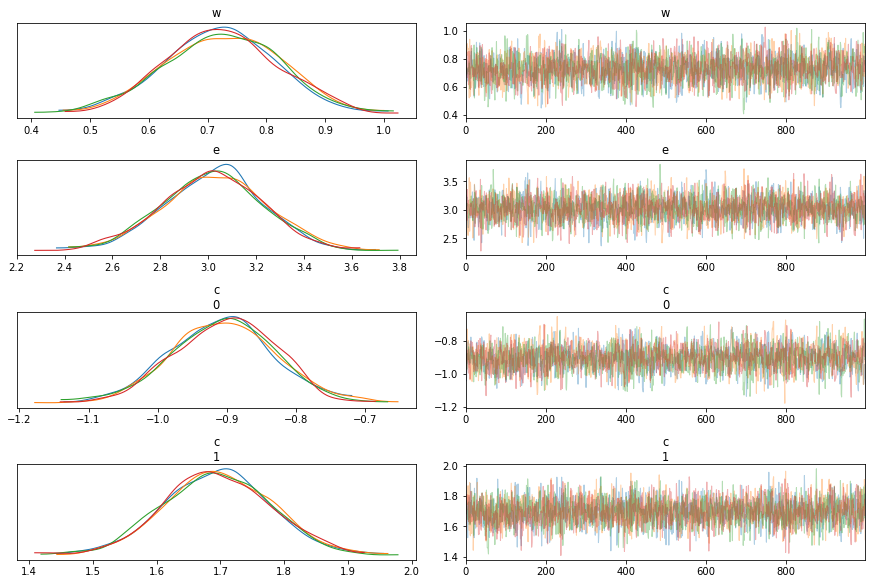

In [12]:
arviz.plot_trace(inference_data, var_names=["w", "e", "c"], compact=False);

In [13]:
train_cls_probs = get_class_probs(params, "ypred")
cls_pred = np.argmax(train_cls_probs, 1) + 1
print_results(train, cls_pred, "Train", dp=4)

Train - exact: 0.5483, out by one: 0.4452, out by two: 0.0065


In [14]:
test_cls_probs = get_class_probs(params, "ypred_test")
cls_pred_test = np.argmax(test_cls_probs, 1) + 1
print_results(test, cls_pred_test, "Test", dp=4)

Test - exact: 0.5566, out by one: 0.4342, out by two: 0.0092
